In [4]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk
import sqlite3
import string
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from keras.models import Sequential
from keras.regularizers import L2, L1L2, L1
from keras import regularizers
from tensorflow.keras import optimizers
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model
import tensorflow as tf
from keras.regularizers import L1L2
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# EDA

##### Data untuk training memiliki format tsv di awal, kami melakukan converting data dari format tsv ke format csv dengan script python. File setelah diconvert kami beri nama "train_preprocess.csv"

In [219]:
# Import Dataset
df_train = pd.read_csv("train_preprocess.csv")

In [220]:
# General Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  11000 non-null  object
 1   labels  11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [221]:
# 5 data teratas dari dataset
df_train.head()

,tweets,labels
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [222]:
# 5 data terbawah dari dataframe
df_train.tail()

,tweets,labels
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative
10999,meskipun sering belanja ke yogya di riau junct...,positive


In [223]:
# Check missing value
df_train.isna().sum()

tweets    0
labels    0
dtype: int64

In [224]:
# Check duplicated data
df_train.duplicated().sum()
print('There are {} duplicated data'.format(df_train.duplicated().sum()))

There are 67 duplicated data


In [225]:
# Drop duplicated data
df_train = df_train.drop_duplicates()
print('There are {} duplicated data'.format(df_train.duplicated().sum()))
print('Duplicated data already dropped')

There are 0 duplicated data
Duplicated data already dropped


In [226]:
# Check rows and columns

shape = df_train.shape
print("Number of columns and number of rows (rows, columns) : \n {}".format(shape))

Number of columns and number of rows (rows, columns) : 
 (10933, 2)


- Tidak ada missing values pada dataset
- Ada 67 duplikat dalam dataset dan sudah di dropped (update menjadi 10933 baris)

In [227]:
# Mengecek jumlah dari masing-masing label pada dataframe
df_train.labels.value_counts()

labels
positive    6383
negative    3412
neutral     1138
Name: count, dtype: int64

Dataset terdiri dari 6383 (58%) label positif, 3412 (31%) label negatif, 1138 (10%) label netral

Terlihat bahwa data imbalance berdasarkan jumlah label. Pada tahap preprocessing data sebelum Modeling harus dilakukan balancing

In [228]:
# Define cleansing function
def cleansing(text):
    # Make sentence being lowercase
    text = text.lower()

    # Remove user, rt, \n, retweet, \t, url, xd
    pattern_1 = r'(user|retweet|\\t|\\r|url|xd)'
    text = re.sub(pattern_1, '', text)

    # Remove mention
    pattern_2 = r'@[^\s]+'
    text = re.sub(pattern_2, '', text)

    # Remove hashtag
    pattern_3 = r'#([^\s]+)'
    text = re.sub(pattern_3, '', text)

    # Remove general punctuation, math operation char, etc.
    pattern_4 = r'[\,\@\*\_\-\!\:\;\?\'\.\"\)\(\{\}\<\>\+\%\$\^\#\/\`\~\|\&\|]'
    text = re.sub(pattern_4, ' ', text)

    # Remove single character
    pattern_5 = r'\b\w{1,1}\b'
    text = re.sub(pattern_5, '', text)

    # Remove emoji
    pattern_6 = r'\\[a-z0-9]{1,5}'
    text = re.sub(pattern_6, '', text)

    # Remove digit character
    pattern_7 = r'\d+'
    text = re.sub(pattern_7, '', text)

    # Remove url start with http or https
    pattern_8 = r'(https|https:)'
    text = re.sub(pattern_8, '', text)

    # Remove (\); ([); (])
    pattern_9 = r'[\\\]\[]'
    text = re.sub(pattern_9, '', text)

    # Remove character non ASCII
    pattern_10 = r'[^\x00-\x7f]'
    text = re.sub(pattern_10, '', text)

    # Remove character non ASCII
    pattern_11 = r'(\\u[0-9A-Fa-f]+)'
    text = re.sub(pattern_11, '', text)

    # Remove multiple whitespace
    pattern_12 = r'(\s+|\\n)'
    text = re.sub(pattern_12, ' ', text)
    
    # Remove whitespace at the first and end sentences
    text = text.rstrip()
    text = text.lstrip()

    # Pattern to look for three or more repetitions of any character, including newlines.
    pattern_13 = re.compile(r"(.)\1{1,}", re.DOTALL)
    text = re.sub(pattern_13, r"\1\1", text)
    return text

#Define tokenization function
def tokenisasi(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

In [229]:
# Apply the cleansing function
df_train['tweets'] = df_train['tweets'].apply(cleansing)

## Feature Engineering

In [230]:
# check total word and total char per row of the datasets
df_train['total_word'] = df_train['tweets'].apply(lambda x: len(x.split()))
df_train['total_char'] = df_train['tweets'].apply(len)
df_train.head()

,tweets,labels,total_word,total_char
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,56,384
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral,18,99
2,lokasi strategis di jalan sumatera bandung tem...,positive,28,172
3,betapa bahagia nya diri ini saat unboxing pake...,positive,15,89
4,duh jadi mahasiswa jangan sombong dong kasih k...,negative,32,200


## Descriptive Statistics

### Mean, Median, Mode

In [231]:
total_word_mean = df_train['total_word'].mean()
total_char_mean = df_train['total_char'].mean()

total_word_median = df_train['total_word'].median()
total_char_median = df_train['total_char'].median()

total_word_mode = df_train['total_word'].mode()
total_char_mode = df_train['total_char'].mode()


print(f"Mean dari total kata : {total_word_mean} \nMean dari total karakter : {total_char_mean}")
print("\n")
print(f"Median dari total kata : {total_word_median} \nMedian dari total karakter : {total_char_median}")
print("\n")
print(f"Mode dari total kata : {total_word_mode} \nMode dari total karakter : {total_char_mode}")

Mean dari total kata : 29.08945394676667 
Mean dari total karakter : 180.66596542577517


Median dari total kata : 25.0 
Median dari total karakter : 153.0


Mode dari total kata : 0    8
Name: total_word, dtype: int64 
Mode dari total karakter : 0    62
Name: total_char, dtype: int64


### Range

Digunakan untuk mencari perbedaan antara nilai terbesar dengan nilai terkecil pada data.

In [232]:
range_total_word = df_train.total_word.max() - df_train.total_word.min() 
range_total_word

84

### IQR dan Mencari Outlier

In [233]:
# cari nilai minimum
p0 = df_train.total_word.min()

# cari nilai maksimum
p100 = df_train.total_word.max()

# cari Quartile 1
q1 = df_train.total_word.quantile(0.25)

#cari Quartile 2
q2 = df_train.total_word.quantile(0.5)

#cari Quartile 3
q3 = df_train.total_word.quantile(0.75)

# cari IQR
iqr = q3 - q1

# cari batas bawah
lower_limit = q1-1.5*iqr

# cari batas atas
upper_limit = q3+1.5*iqr

# menentukan batas outlier dari data yang kita punya :
# Cek apakah ada outlier dari batas bawah
print("Batas Bawah 'total_word' :", lower_limit)
print("Nilai minimum =", p0)
if lower_limit < p0 :
  print("Tidak ada outlier dari sisi batas bawah")
else :
  print("Ada outlier dari sisi batas bawah")

# Cek apa ada outlier dari batas atas
print("="*10)
print("Batas Atas 'total_word' :", upper_limit)
print("Nilai maksimum =", p100)
if upper_limit >  p100 :
  print("Tidak ada outlier dari sisi batas atas")
else :
  print("Ada outlier dari sisi batas atas")

Batas Bawah 'total_word' : -28.0
Nilai minimum = 1
Tidak ada outlier dari sisi batas bawah
Batas Atas 'total_word' : 84.0
Nilai maksimum = 85
Ada outlier dari sisi batas atas


### Variance

Digunakan untuk mengukur seberapa menyebar data yang ada dari mean-nya. Jika nilai variance dari suatu variabel/kolom lebih besar atau lebih kecil mean, maka nilai dari suatu variabel/kolom tersebut menjauhi mean.

In [234]:
print(f"Variance dari total kata : {df_train['total_word'].var()}")
print(f"Variance dari total karakter : {df_train['total_char'].var()}")

Variance dari total kata : 341.4182687559516
Variance dari total karakter : 13275.283214940993


### Standard Deviation

Digunakan untuk mengukur penyebaran observasi dalam kumpulan data relatif terhadap rata-ratanya. Jika nilai standard deviation dari suatu variabel/kolom lebih besar atau lebih kecil mean, maka data dari suatu variabel/kolom tersebut menjauhi mean.


In [235]:
print(f"Standard Deviasi dari total kata : {df_train['total_word'].std()}")
print(f"Standard Deviasi dari total karakter : {df_train['total_char'].std()}")

Standard Deviasi dari total kata : 18.477507103393346
Standard Deviasi dari total karakter : 115.21841525963197


### Skewness
Merupakan suatu cara untuk mengukur ketidaksimetrisan suatu distribusi nilai.

*   Apabila nilai skewness = 0, maka menunjukkan data berdistribusi normal.
*   Apabila nilai skewness < 0, maka menunjukkan skewness bernilai negatif.
*   Apabila nilai skewness > 0, maka menunjukkan skewness bernilai positif.

In [236]:
print(f"Skewness dari total kata : {df_train['total_word'].skew()}")
print(f"Skewness dari total karakter : {df_train['total_char'].skew()}")

Skewness dari total kata : 0.5348839898366986
Skewness dari total karakter : 0.5683638210607023


Dapat terlihat bahwa total word dan total karakter dari data memiliki skewness positif (Cenderung jatuh ke kanan)

### Kurtosis
Merupakan suatu cara untuk menunjukan derajat keruncingan, semakin besar nilai kurtosis maka kurva semakin runcing.

Kurtosis memiliki kondisi sebagai berikut:

*   Kurtosis yang memiliki nilai 3 berarti memiliki Distribusi Normal
*   Jika nilai Kurtosis kurang dari 3, dikatakan bersifat playkurtik, yang berarti cenderung menghasilkan lebih sedikit nilai outlier.
*   Jika nilai kurtosis lebih besar dari 3, dikatakan leptokurtik, yang berarti cenderung menghasilkan lebih besar nilai outlier.

In [237]:
print(f"Kurtosis dari total kata : {df_train['total_word'].kurtosis()}")
print(f"Kurtosis dari total karakter : {df_train['total_char'].kurtosis()}")

Kurtosis dari total kata : -0.8098562083645962
Kurtosis dari total karakter : -0.7503017623016452


## Visualization

Selain dengan pendekatan Descriptive Statistic, untuk mengetahui insight melalui Univariate Analysis bisa menggunakan visualisasi. 

Berikut contoh visualisasi Pie Chart untuk melihat persebaran total sentimen per kelasnya.

Berdasarkan gambar di bawah terlihat sentimen terbanyak ada di sentimen positif, selanjutnya sentimen negatif, dan yang terakhir sentimen netral. 

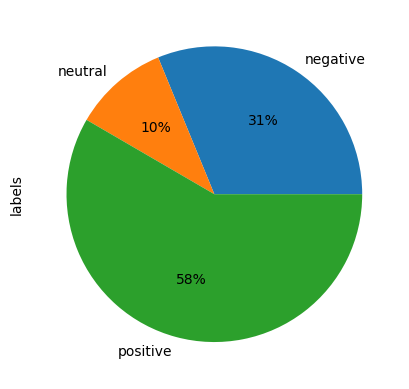

In [238]:
df_train.groupby('labels').labels.count().plot(autopct='%1.0f%%', kind='pie')
plt.savefig("pie_labels.png", bbox_inches = 'tight', dpi=300)

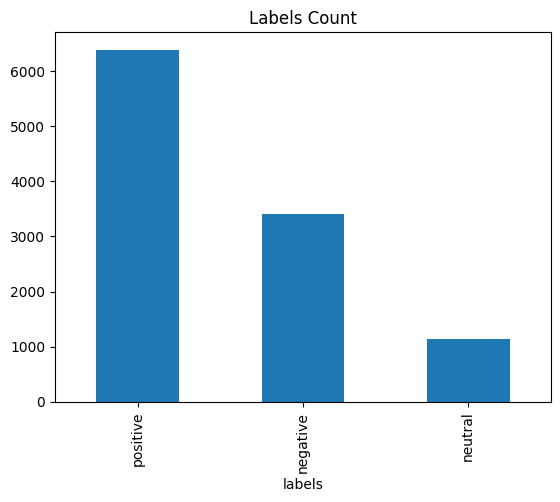

In [239]:
df_train.labels.value_counts().plot(kind='bar')
plt.title("Labels Count")
plt.savefig("labels_count.png", bbox_inches = 'tight', dpi=300)

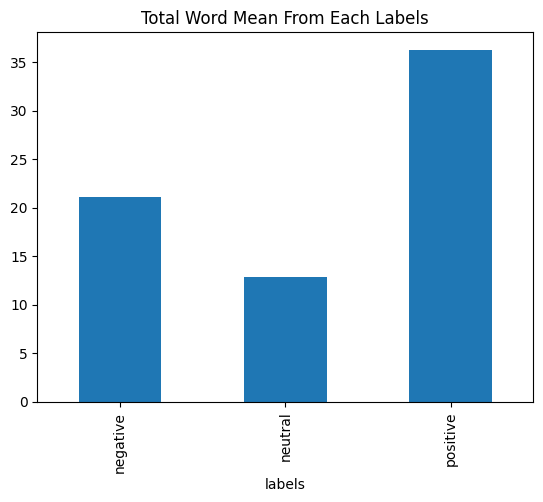

In [240]:
df_train.groupby('labels').total_word.mean().plot(kind='bar')
plt.title("Total Word Mean From Each Labels")
plt.savefig("word_class.png", bbox_inches = 'tight', dpi=300)

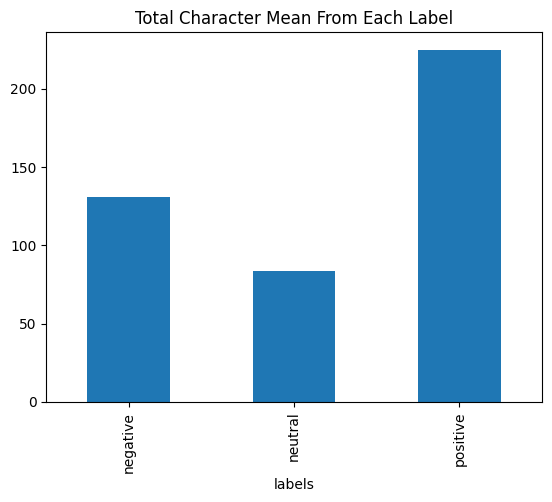

In [241]:
df_train.groupby('labels').total_char.mean().plot(kind='bar')
plt.title("Total Character Mean From Each Label")
plt.savefig("char_class.png", bbox_inches = 'tight', dpi=300)

## Histogram

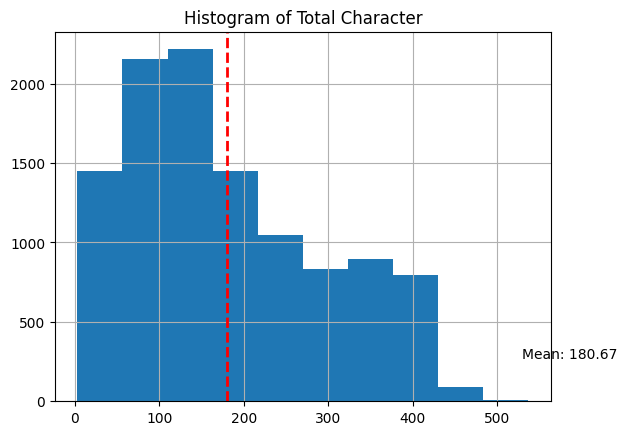

In [242]:
df_train.total_char.hist()
plt.title("Histogram of Total Character")
plt.axvline(total_char_mean, color='r', linestyle='dashed', linewidth=2)
plt.text(x = df_train.total_char.max()-8, y = df_train.total_char.max()*0.5, s = 'Mean: {:.2f}'.format(total_char_mean), size = 10)
plt.savefig("hist_total_char.png", dpi=300)

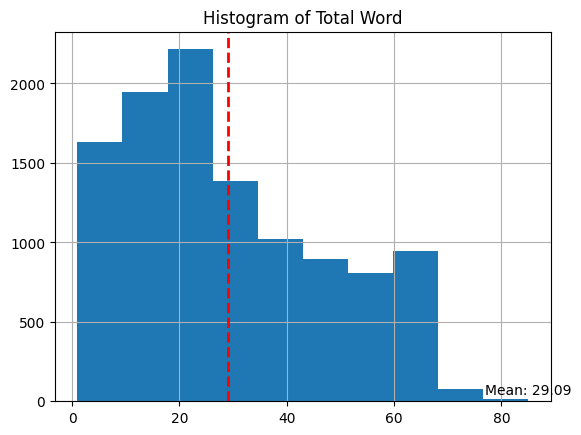

In [243]:
df_train.total_word.hist()
plt.title("Histogram of Total Word")
plt.axvline(total_word_mean, color='r', linestyle='dashed', linewidth=2)
plt.text(x = df_train.total_word.max()-8, y = df_train.total_word.max()*0.5, s = 'Mean: {:.2f}'.format(total_word_mean), size = 10)
plt.savefig("hist_total_word.png", bbox_inches = 'tight', dpi=300)

### Histogram & Filter Sentiment

Kita bisa memfilter data berdasarkan sentimen setelah itu memvisualisasikannya dalam bentuk Histogram.


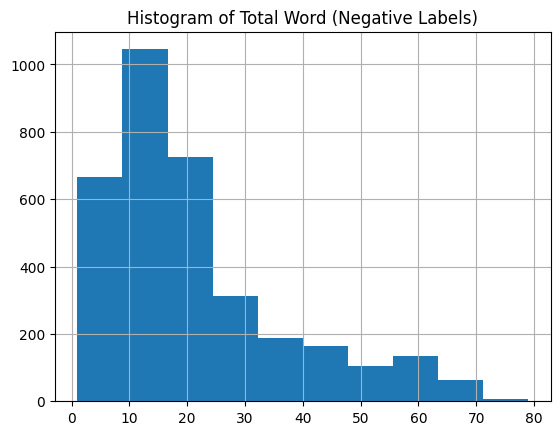

In [244]:
# misal visualisasi hanya berdasarkan sentimen negatif 
df_negative = df_train.loc[df_train['labels'] == 'negative']
df_negative['total_word'].hist()
plt.title("Histogram of Total Word (Negative Labels)")
plt.savefig("hist_total_word_neg.png", bbox_inches = 'tight', dpi=300)

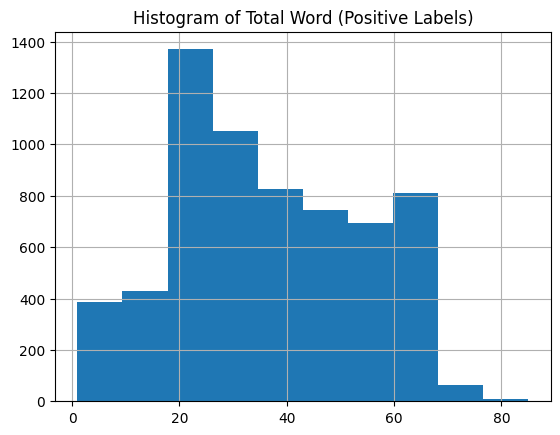

In [245]:
# misal visualisasi hanya berdasarkan sentimen positive
df_positive = df_train.loc[df_train['labels'] == 'positive']
df_positive['total_word'].hist()
plt.title("Histogram of Total Word (Positive Labels)")
plt.savefig("hist_total_word_pos.png", bbox_inches = 'tight', dpi=300)

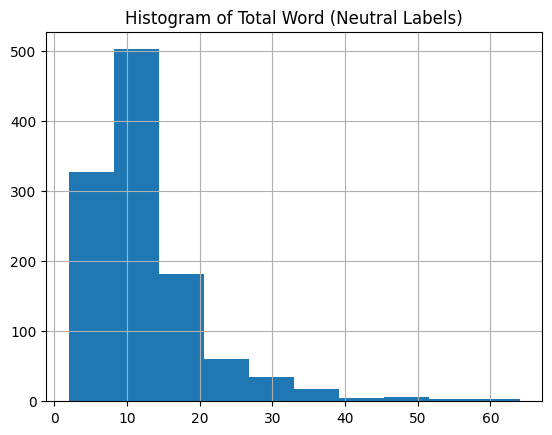

In [246]:
# misal visualisasi hanya berdasarkan sentimen neutral
df_neutral = df_train.loc[df_train['labels'] == 'neutral']
df_neutral['total_word'].hist()
plt.title("Histogram of Total Word (Neutral Labels)")
plt.savefig("hist_total_word_neut.png", bbox_inches = 'tight', dpi=300)

## Wordcloud

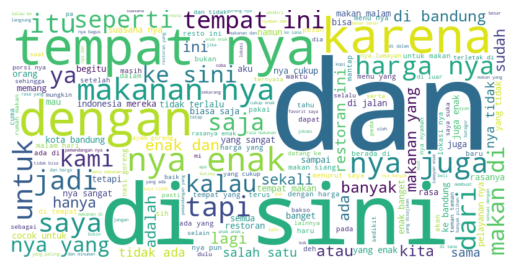

In [247]:
# merge all text from dataframe (df)
text = ' '.join(df_train['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud.png", bbox_inches = 'tight', dpi=300)

In [248]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_train['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('nya', 13458), ('yang', 9317), ('dan', 7879), ('di', 7727), ('tidak', 4373), ('saya', 4301), ('dengan', 4008), ('enak', 3719), ('makanan', 3587), ('tempat', 3550)]


## Wordcloud (Negative Labels)

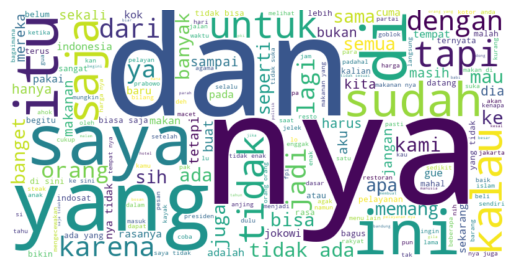

In [249]:
# merge all text from dataframe (df)
df_negative = df_train.loc[df_train['labels'] == 'negative']

text = ' '.join(df_negative['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud_neg.png", bbox_inches = 'tight', dpi=300)

In [250]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_negative['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('nya', 2342), ('tidak', 1932), ('yang', 1733), ('dan', 1243), ('di', 1206), ('saya', 1082), ('ini', 761), ('saja', 655), ('dengan', 640), ('itu', 623)]


## Wordcloud (Positive Labels)

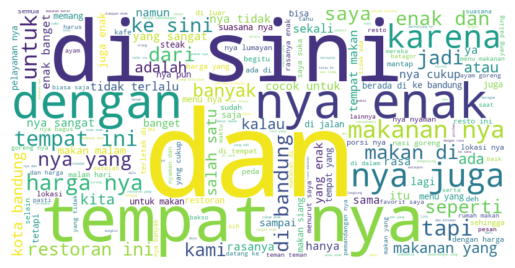

In [251]:
# merge all text from dataframe (df)
df_positive = df_train.loc[df_train['labels'] == 'positive']

text = ' '.join(df_positive['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud_pos.png", bbox_inches = 'tight', dpi=300)

In [252]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_positive['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('nya', 10911), ('yang', 7365), ('dan', 6421), ('di', 6185), ('enak', 3457), ('dengan', 3238), ('tempat', 3229), ('makanan', 3188), ('saya', 3090), ('ini', 2690)]


## Wordcloud (Netural Labels)

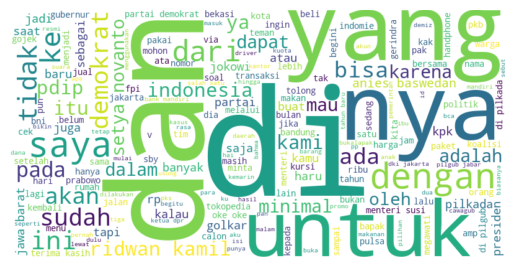

In [253]:
# merge all text from dataframe (df)
df_neutral = df_train.loc[df_train['labels'] == 'neutral']

text = ' '.join(df_neutral['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud_neut.png", bbox_inches = 'tight', dpi=300)

In [254]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_neutral['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('di', 336), ('yang', 219), ('dan', 215), ('nya', 205), ('untuk', 144), ('dengan', 130), ('saya', 129), ('demokrat', 96), ('tidak', 92), ('ke', 91)]


## Counter untuk Mencari Bag of Words dari tiap Label

In [255]:
from collections import Counter

def get_word_frequency(label):
    words = []
    for text in df_train[df_train['labels'] == label]['tweets']:
        words += text.split()
    word_freq = Counter(words)
    return word_freq

pos_word_freq = get_word_frequency('positive')
neg_word_freq = get_word_frequency('negative')
ntrl_word_freq = get_word_frequency('neutral')

### Kata yang paling sering muncul pada label "positive"

In [256]:
pos_word_freq.most_common(10)

[('nya', 10911),
 ('yang', 7365),
 ('dan', 6421),
 ('di', 6185),
 ('enak', 3457),
 ('dengan', 3238),
 ('tempat', 3229),
 ('makanan', 3188),
 ('saya', 3090),
 ('ini', 2690)]

### Kata yang paling sering muncul pada label "negative"

In [257]:
neg_word_freq.most_common(10)

[('nya', 2342),
 ('tidak', 1932),
 ('yang', 1733),
 ('dan', 1243),
 ('di', 1206),
 ('saya', 1082),
 ('ini', 761),
 ('saja', 655),
 ('dengan', 640),
 ('itu', 623)]

### Kata yang paling sering muncul pada label "neutral"

In [258]:
ntrl_word_freq.most_common(10)

[('di', 336),
 ('yang', 219),
 ('dan', 215),
 ('nya', 205),
 ('untuk', 144),
 ('dengan', 130),
 ('saya', 129),
 ('demokrat', 96),
 ('tidak', 92),
 ('ke', 91)]

# Bivariate Analysis

In [259]:
df_train_corr = df_train.select_dtypes(include=['int64', 'float64'])
df_train_corr.corr()

,total_word,total_char
total_word,1.000000,0.993368
total_char,0.993368,1.000000


Korelasi antara total kata dengan total karakter dari masing-masing data sangat tinggi. Seperti kita ketahui, kata berasal dari kumpulan karakter. Mari kita buktikan dengan scatter plot

### Scatter Plot

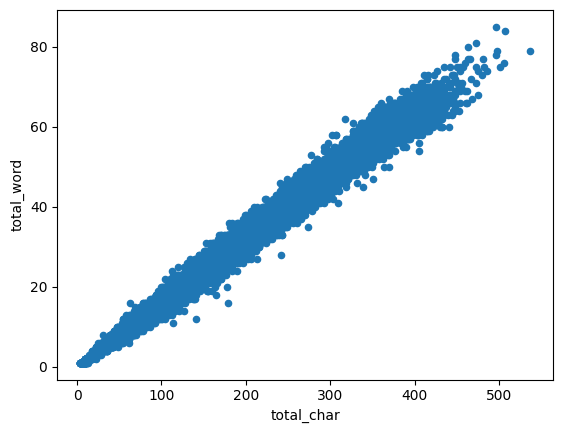

In [260]:
df_train.plot(x="total_char", y="total_word", kind='scatter')
plt.savefig("scatter_plot.png", bbox_inches = 'tight', dpi=300)

## Heatmap

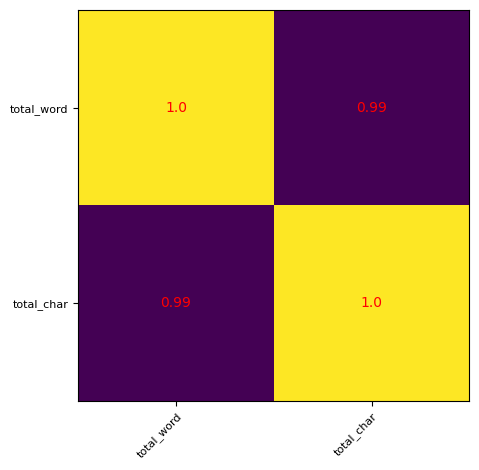

In [261]:
# get correlation matrix
corr = df_train_corr.corr()
fig, ax = plt.subplots()
# create heatmap
im = ax.imshow(corr.values)
# set labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, fontsize=8)
ax.set_yticklabels(corr.columns, fontsize=8)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, np.around(corr.iloc[i, j], decimals=2), ha="center", va="center", color="red", fontsize=10) # decrease font size of text annotations
plt.tight_layout() # adjust subplots to fit the figure size
plt.savefig("heatmap.png", bbox_inches = 'tight', dpi=300)
plt.show()

# **Modeling**

#### Sebelum tahap modeling ada beberapa proses, yaitu:
* Preprocessing Data (Cleansing data, cek outlier, splitting data, mengubah data teks menjadi numerikal)
* Balancing data (karena diketahui saat EDA pada data train terdapat imbalance label)

Selain menggunakan library regex, selanjutnya mengganti kata-kata non-standar menjadi kata-kata yang lebih standar dengan bantuan kamus 'kamusalay' dan RDBMS (SQlite).

In [262]:
# create database connection
conn = sqlite3.connect('data.db')

In [263]:
# import kamusalay
kamusalay = pd.read_csv('new_kamusalay.csv',encoding='latin-1',names=['kata_alay','normal'])

# Connect kamusalay to database

kamusalay.to_sql('kamusalay', conn, if_exists='replace',index=False)
kamusalay=pd.DataFrame(kamusalay)
kamusalay

,kata_alay,normal
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [264]:
# Retrieve kamusalay

db = sqlite3.connect('data.db', check_same_thread = False)
q_kamusalay = 'SELECT * FROM kamusalay'
t_kamusalay = pd.read_sql_query(q_kamusalay, db)

In [265]:
# Change non standard words to become more standard words

alay_dict = dict(zip(t_kamusalay['kata_alay'], t_kamusalay['normal']))
def alay_to_normal(text):
    for word in alay_dict:
        return ' '.join([alay_dict[word] if word in alay_dict else word for word in text.split(' ')])

In [266]:
df_train.head()

,tweets,labels,total_word,total_char
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,56,384
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral,18,99
2,lokasi strategis di jalan sumatera bandung tem...,positive,28,172
3,betapa bahagia nya diri ini saat unboxing pake...,positive,15,89
4,duh jadi mahasiswa jangan sombong dong kasih k...,negative,32,200


In [267]:
# drop total word and total char columns
df_train_drop1 = df_train.drop('total_word', axis=1)
df_train_drop2 = df_train_drop1.drop('total_char', axis=1)

In [268]:
# check the dataframe after dropping total word and total char columns
df_train_drop2.head()

,tweets,labels
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatera bandung tem...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh jadi mahasiswa jangan sombong dong kasih k...,negative


In [269]:
# copy the dataset to make a new clean dataframe
data = df_train_drop2.copy()

In [270]:
# new dataframe top 5 data
data.head()

,tweets,labels
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatera bandung tem...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh jadi mahasiswa jangan sombong dong kasih k...,negative


In [271]:
# add cleansing function from kamusalay
def cleansingnew(text):
    text = cleansing(text)
    text = alay_to_normal(text)
    return text

In [272]:
# Apply cleansing function to dataset

data['tweets'] = data['tweets'].apply(cleansingnew)
data.head()

,tweets,labels
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan mmbri hujjah partai apa ...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


In [273]:
# Old tweet and new tweet comparation

print('Old tweet: {}'.format(df_train['tweets'].iloc[16]))
print('\t')
print('New tweet: {}'.format(data['tweets'].iloc[16]))

Old tweet: setiap bumn dibentuk dengan uu bukan dibentuk dengan uu
	
New tweet: setiap badan usaha milik negara dibentuk dengan undang undang bukan dibentuk dengan undang undang


## Data Storing

Dataset yang dibersihkan akan disimpan dalam database (SQlite)

In [275]:
# Connect cleaned data to database

data.to_sql('data', conn, if_exists='replace',index=False)
data=pd.DataFrame(data)
data

,tweets,labels
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan mmbri hujjah partai apa ...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative
...,...,...
10993,demokrat dorong upaya kemandirian energi nasional,neutral
10994,tidak bosan,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10998,pagi pagi di tol pasteur sudah macet parah bik...,negative


In [276]:
# Close the database

conn.commit()
conn.close()

# Neural Network (NN)

Karena kita sudah melakukan text processing & cleansing, maka untuk proses modelling Neural Network (NN) kita bisa langsung memanggil dataset yang sudah distoring di database sqlite3.

In [5]:
# Load dataset from database
db = sqlite3.connect('data.db', check_same_thread = False)
q_data = 'SELECT * FROM data'
data = pd.read_sql_query(q_data, db)
data.head()

,tweets,labels
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan mmbri hujjah partai apa ...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


Setelah itu kita lakukan Feature Extraction menggunakan metode Bag of Words

In [6]:
# Kita simpan teks ke dalam sebuah variabel
data_preprocessed = data.tweets.tolist()

In [7]:
data_preprocessed

['warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung tahu berkualitas dipadu keahlian memasak dipadu kretivitas jadilah warung yang menyajikan menu utama berbahan tahu ditambah menu umum lain seperti ayam semuanya selera indonesia harga cukup terjangkau jangan melewati tahu bletoka nya tidak kalah dengan yang asli dari tegal',
 'mohon ulama lurus dan mmbri hujjah partai apa yang harus diwlh agar suara islam tidak pecah pecah',
 'lokasi strategis di jalan sumatra bandung tempat nya nyaman terutama sofa di lantai paella nya enak sangat pas dimakan dengan minum bir dingin appetiser nya juga enak enak',
 'betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus menetapkan beli lagi',
 'aduh jadi mahasiswa jangan sombong dong kasih kartu kuning segala belajar dulu yang baik tidak usahlah ikut ikut politik nanti sudah selesai kuliah nya mau ikut politik juga tidak telat dasar mahasiswa',
 'makanan beragam harga makanan d

In [8]:
# Untuk melakukan Feature Extraction, kita menggunakan library "Sklearn atau scikit-learn".
# Sklearn adalah library untuk melakukan task-task Machine Learning.
# "CountVectorizer" merupakan salah satu modul untuk melakukan "BoW"

from sklearn.feature_extraction.text import CountVectorizer

# Kita proses Feature Extraction
count_vect = CountVectorizer()
count_vect.fit(data_preprocessed)

X = count_vect.transform(data_preprocessed)
print ("Feature Extraction selesai")

Feature Extraction selesai


In [9]:
import pickle

pickle.dump(count_vect, open("feature.p", "wb"))

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [10]:
from sklearn.model_selection import train_test_split

classes = data.labels

In [11]:
classes

0        positive
1         neutral
2        positive
3        positive
4        negative
           ...   
10928     neutral
10929    positive
10930    positive
10931    negative
10932    positive
Name: labels, Length: 10933, dtype: object

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size = 0.2)

Jalankan training dengan metode Neural Network. "MLPClassifier" merupakan salah satu modul dari "Neural Network" pada library Sklearn.

In [13]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(activation='logistic')
model.fit(X_train, y_train)

print ("Training selesai")

Training selesai


In [14]:
pickle.dump(model, open("model_nn.p", "wb"))

Langkah selanjutnya adalah "Evaluation". Module "classification_report" dari Sklearn merupakan salah satu modul untuk melakukan "Evaluation". Pada tahap evaluasi ini kita akan menerapkan metode evaluasi Accuracy, Precision, Recall dan F1-Score.

In [15]:
from sklearn.metrics import classification_report

test = model.predict(X_test)

print ("Testing selesai")

print(classification_report(y_test, test)) 

Testing selesai
              precision    recall  f1-score   support

    negative       0.73      0.74      0.74       660
     neutral       0.75      0.68      0.72       231
    positive       0.87      0.88      0.88      1296

    accuracy                           0.82      2187
   macro avg       0.79      0.77      0.78      2187
weighted avg       0.82      0.82      0.82      2187



Hasilnya nilai F1 Score ada pada angka 0.74 untuk Negative, 0.70 untuk Neutral, dan 0.86 untuk Positive. Hasil ini bisa dikatakan cukup bagus untuk sebuah model.

Mekanisme evaluasi selanjutnya menggunakan "Cross Validation", yaitu merotasi porsi testing dari dataset agar bisa melihat model yang sudah kita buat stabil ketika dihadapkan pada data yang berbeda.

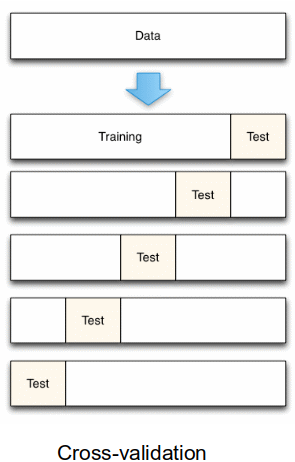

In [16]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = classes

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    # clf = MLPClassifier()
    clf = MLPClassifier(activation='logistic')
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

    # for the current fold only    
    accuracy = accuracy_score(target_test,preds)

    print("Training ke-", iteration)
    print(classification_report(target_test,preds))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Training ke- 1
              precision    recall  f1-score   support

    negative       0.74      0.76      0.75       690
     neutral       0.79      0.69      0.74       220
    positive       0.87      0.88      0.87      1277

    accuracy                           0.82      2187
   macro avg       0.80      0.78      0.79      2187
weighted avg       0.82      0.82      0.82      2187

Training ke- 2
              precision    recall  f1-score   support

    negative       0.73      0.76      0.74       667
     neutral       0.78      0.63      0.70       219
    positive       0.86      0.87      0.87      1301

    accuracy                           0.81      2187
   macro avg       0.79      0.75      0.77      2187
weighted avg       0.81      0.81      0.81      2187

Training ke- 3
              precision    recall  f1-score   support

    negative       0.76      0.75      0.76       695
     neutral       0.78      0.68      0.73       213
    positive       0.86      0

Hasilnya nilai rata-rata accuracy pada angka 0.81. Ini menunjukkan model kita cukup stabil pada angka 0.81.

In [18]:
# Save the model

# Simpan model ke dalam file
with open('model_nn.pkl', 'wb') as file:
    pickle.dump(clf, file)
print('Model has created!')

Model has created!


Asumsi kita sudah oke dengan model yang dibuat, selanjutnya melakukan predict pada model untuk mengetes jika model sudah berjalan.

In [309]:
original_text =  '''
Minuman ini tidak enak
'''
# Feature Extraction
text = count_vect.transform([cleansing(original_text)])

# Kita prediksi sentimennya
result = model.predict(text)[0]
print("Sentiment:")
print()
print(result)

Sentiment:

negative


# Long Short Term Memory Network (LSTM)

## Load Libraries and Dataset

In [322]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
import re

In [323]:
# Load dataset from database

db = sqlite3.connect('data.db', check_same_thread = False)
q_data = 'SELECT * FROM data'
data = pd.read_sql_query(q_data, db)
data.head()

,tweets,labels
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan mmbri hujjah partai apa ...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


In [324]:
# Check data distribution

data['labels'].value_counts()

labels
positive    6383
negative    3412
neutral     1138
Name: count, dtype: int64

## Feature-Label Classification

In [325]:
# Oversampling neutral label to be equal with negative label

data_pos = data[data['labels']=='positive']
data_neu = data[data['labels']=='neutral']
data_neg = data[data['labels']=='negative']

df_neu = data_neu.sample(data_neg.shape[0], replace = True)

data = pd.concat([data_pos, df_neu, data_neg])

# Group data tweet

pos_tweet = data.loc[data['labels']=='positive'].tweets.tolist()
neg_tweet = data.loc[data['labels']=='negative'].tweets.tolist()
neu_tweet = data.loc[data['labels']=='neutral'].tweets.tolist()

# Group data label

pos_label = data.loc[data['labels']=='positive'].labels.tolist()
neg_label = data.loc[data['labels']=='negative'].labels.tolist()
neu_label = data.loc[data['labels']=='neutral'].labels.tolist()

In [326]:
# Final sentiment data check

total_data = pos_tweet + neg_tweet + neu_tweet
labels = pos_label + neu_label + neg_label

print("Positive: %s, Neutral: %s, Negative: %s" % (len(pos_tweet), len(neu_tweet), len(neg_tweet)))
print("Total data: %s" % len(total_data))
print("Total labels: %s" % len(labels))

Positive: 6383, Neutral: 3412, Negative: 3412
Total data: 13207
Total labels: 13207


## Feature Extraction

Feature Extraction yang dilakukan adalah tokenizer (mengubah teks menjadi barisan bilangan bulat atau menjadi vektor) dan pad sequence (mengubah daftar barisan menjadi vektor/array 2D). Hasil ekstraksi fitur akan disimpan dengan Library Pickle.

In [327]:
# Tokenizer and pad sequence

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [328]:
# Feature extraction for labels

Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [329]:
# Split train-test data with proportion 80:20

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model Training

Melakukan pelatihan model menggunakan algoritma LSTM. Kemudian melakukan cross validation sebanyak 5 kali untuk memeriksa kestabilan kinerja.

In [330]:
##### Model training and cross validation

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]
    
    # Create model architecture

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.5))
    model.add(Dense(3,activation='softmax'))
    # model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.0005)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    history = model.fit(data_train, target_train, epochs=50, batch_size=32, 
                        validation_data=(data_test, target_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", round(average_accuracy,4))

Epoch 1/50
331/331 [==============================] - 150s 428ms/step - loss: 0.6297 - accuracy: 0.7329 - val_loss: 0.3624 - val_accuracy: 0.8740
Epoch 2/50
331/331 [==============================] - 136s 412ms/step - loss: 0.2772 - accuracy: 0.9010 - val_loss: 0.2644 - val_accuracy: 0.9012
Epoch 3/50
331/331 [==============================] - 126s 381ms/step - loss: 0.1669 - accuracy: 0.9430 - val_loss: 0.2404 - val_accuracy: 0.9020
Epoch 4/50
331/331 [==============================] - 137s 413ms/step - loss: 0.1215 - accuracy: 0.9594 - val_loss: 0.2404 - val_accuracy: 0.9058
Epoch 5/50
331/331 [==============================] - 124s 376ms/step - loss: 0.0909 - accuracy: 0.9685 - val_loss: 0.2555 - val_accuracy: 0.9061
Epoch 6/50
331/331 [==============================] - 122s 369ms/step - loss: 0.0662 - accuracy: 0.9762 - val_loss: 0.2972 - val_accuracy: 0.9035
Epoch 6: early stopping
83/83 [==============================] - 4s 38ms/step
Training ke- 1
              precision    reca

## Evaluation

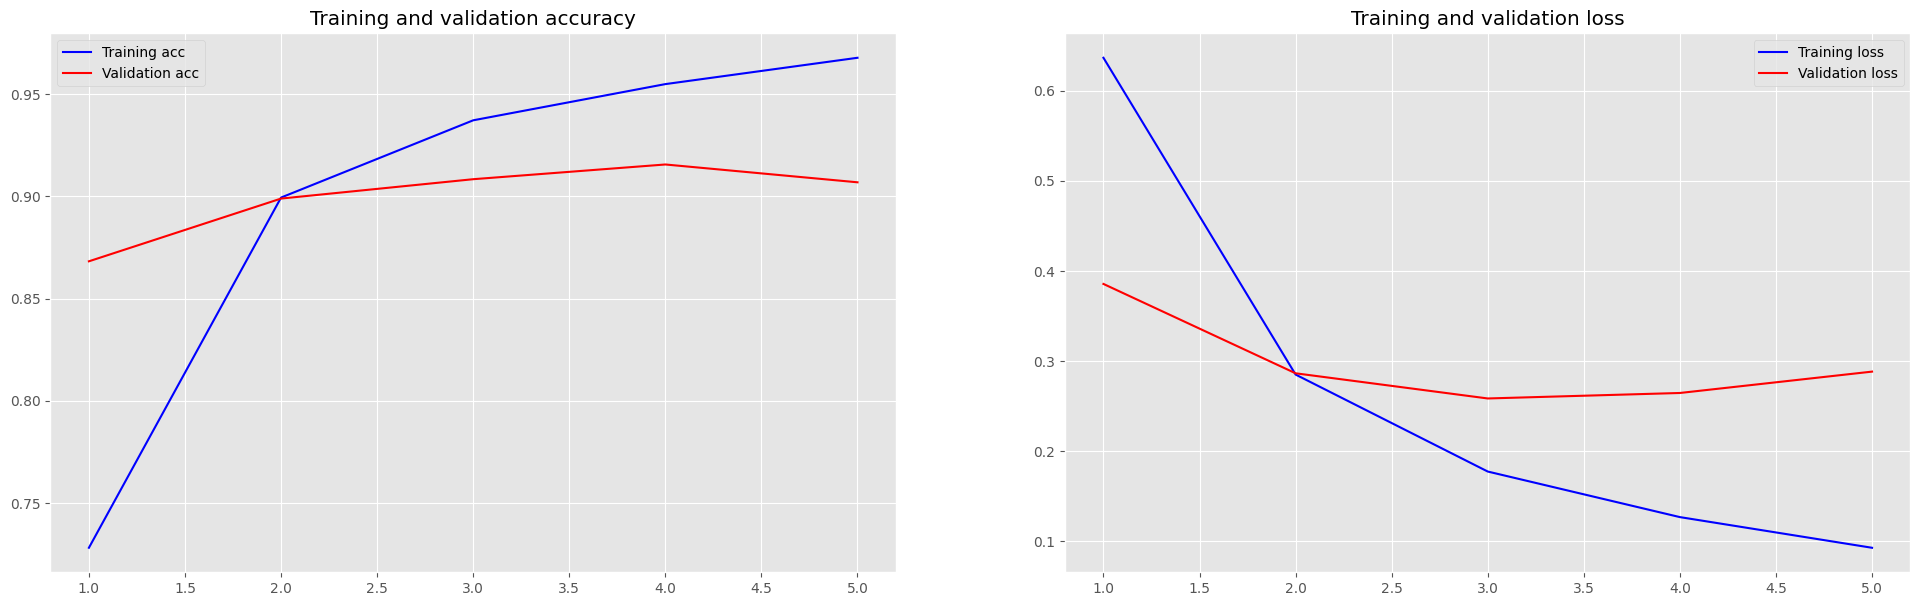

In [331]:
# Visualize it

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

- Dengan cross validation 5 kali, performa model stabil dengan akurasi 96,5%.
- Terlihat performa dengan minimal loss terjadi pada epoch kedua
- Majority model training dihentikan setelah epoch keenam

In [332]:
# Save the model

model.save('model_lstm.h5')
print("Model has created!")

d:\BINAR_CHALLENGE\PLATINUM_CHALLENGE\plat_challenge_main\plat_challenge_main\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


In [334]:
input_text = """
Minumannya enak """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 1s 1s/step
Text:  minumannya enak 
Sentiment: positive


In [335]:
input_text = """
Semua berjalan normal """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 1s 1s/step
Text:  semua berjalan normal 
Sentiment: neutral
